# Segmentacion Online dataset

## Librerias

In [1]:
import pandas as pd
import numpy as np 
import matplotlib as plt
import seaborn as sns
import datetime 

from sklearn.preprocessing import scale #importa libreria sklearn para escalar la data
from sklearn import metrics #importa libreria para evaluar el resultado de los clusters-silueta
from pycaret.classification import *

## Dataset y métricas

In [2]:
dataset = pd.read_excel('../DB/Online_Retail.xlsx')
dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
dataset['TotalSum'] = dataset.Quantity * dataset.UnitPrice
dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [4]:
#Creacion de fechas
snapshot_date = max(dataset.InvoiceDate) + datetime.timedelta(days=1)

In [5]:
# Aggregate data on a customer level
datamart = dataset.groupby(['CustomerID']).agg({
'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
'InvoiceNo': 'count',
'TotalSum': 'sum'})

# Rename columns for easier interpretation
datamart.rename(columns = {'InvoiceDate': 'Recency',
'InvoiceNo': 'Frequency',
'TotalSum': 'Monetary'}, inplace=True)

In [6]:
# Check the first rows
datamart.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,2,0.00
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


In [7]:
# Aggregate data on a customer level
datamart2 = dataset.groupby(['CustomerID']).agg({
'InvoiceDate': lambda x: (snapshot_date - x.min()).days})

# Rename columns for easier interpretation
datamart2.rename(columns = {'InvoiceDate': 'Tenure'}, inplace=True)

In [8]:
datamart2.head()

,Tenure
CustomerID,
12346.0,326
12347.0,367
12348.0,358
12349.0,19
12350.0,310


In [9]:
datamart_rfm = datamart.merge(datamart2, on='CustomerID', how='inner')

In [10]:
datamart_rfm.head()

,Recency,Frequency,Monetary,Tenure
CustomerID,,,,
12346.0,326,2,0.00,326
12347.0,2,182,4310.00,367
12348.0,75,31,1797.24,358
12349.0,19,73,1757.55,19
12350.0,310,17,334.40,310


In [11]:
datamart_rfm["R"]=datamart_rfm["Recency"].rank(pct=True)*100
datamart_rfm["F"]=datamart_rfm["Frequency"].rank(pct=True)*100
datamart_rfm["M"]=datamart_rfm["Monetary"].rank(pct=True)*100
datamart_rfm["T"]=datamart_rfm["Tenure"].rank(pct=True)*100

datamart_rfm.head()

,Recency,Frequency,Monetary,Tenure,R,F,M,T
CustomerID,,,,,,,,
12346.0,326,2,0.00,326,96.203111,2.493138,1.075023,73.353156
12347.0,2,182,4310.00,367,3.465233,87.991766,92.726441,89.524245
12348.0,75,31,1797.24,358,62.294145,41.834401,77.630375,80.272187
12349.0,19,73,1757.55,19,27.916285,66.285453,76.989936,3.110704
12350.0,310,17,334.40,310,94.510522,24.759835,29.666057,67.532022


## Pre-procesado

In [12]:
datamart_rfm = datamart_rfm[['R', 'F', 'M','T']]
datamart_rfm.head()

,R,F,M,T
CustomerID,,,,
12346.0,96.203111,2.493138,1.075023,73.353156
12347.0,3.465233,87.991766,92.726441,89.524245
12348.0,62.294145,41.834401,77.630375,80.272187
12349.0,27.916285,66.285453,76.989936,3.110704
12350.0,94.510522,24.759835,29.666057,67.532022


In [13]:
# Quitar sesgo
datamart_log = np.log(datamart_rfm)
datamart_log.describe()

,R,F,M,T
count,4372.000000,4372.000000,4372.000000,4372.000000
mean,3.613912,3.611809,3.606341,3.606537
std,0.957564,0.966549,0.995253,0.994073
min,0.192486,-0.088926,-3.777806,-3.084658
25%,3.227076,3.209223,3.219562,3.218418
50%,3.912252,3.916815,3.912252,3.910879
75%,4.317488,4.319164,4.317564,4.320077
max,4.604484,4.605170,4.605170,4.599436


In [14]:
# Normalizar variables
datamart_normalized = scale(datamart_log)
print(datamart_normalized)

[[ 0.99487701 -2.79196942 -3.55125974  0.69293418]
 [-2.47649654  0.89548829  0.92782271  0.8933688 ]
 [ 0.54097102  0.12614366  0.74925992  0.7836196 ]
 ...
 [-1.06098194 -0.68394002 -0.99539372 -0.34942555]
 [-1.56962059  1.02049481  0.79271801  0.7444529 ]
 [ 0.23813791  0.58418838  0.75516407  0.03976456]]


## Clustering

### Librerías clustering

In [15]:
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib import pyplot as plt

### Metodo del codo

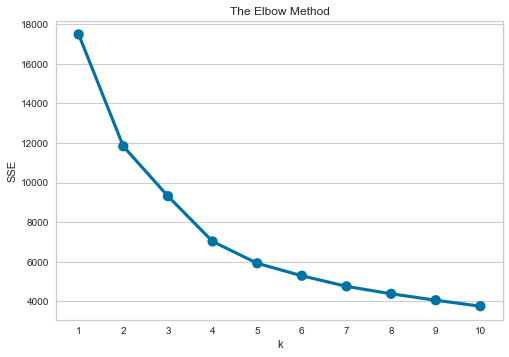

In [16]:
# Fit KMeans and calculate SSE for each *k*
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1,init= "k-means++")
    kmeans.fit(datamart_normalized)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster center

# Plot SSE for each *k*
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [17]:
kmeans = KMeans(n_clusters=4, random_state=1 , init= "k-means++")
kmeans.fit(datamart_normalized)

KMeans(n_clusters=4, random_state=1)

In [18]:
# Extract cluster labels from labels_ attribute
cluster_labels = kmeans.labels_

In [19]:
datamart_rfm_k = datamart_rfm.assign(Cluster = cluster_labels)
datamart_rfm_k.head()

,R,F,M,T,Cluster
CustomerID,,,,,
12346.0,96.203111,2.493138,1.075023,73.353156,3
12347.0,3.465233,87.991766,92.726441,89.524245,0
12348.0,62.294145,41.834401,77.630375,80.272187,1
12349.0,27.916285,66.285453,76.989936,3.110704,2
12350.0,94.510522,24.759835,29.666057,67.532022,1


In [20]:
datamart_rfm_k.groupby(['Cluster']).agg({
'R': 'mean',
'F': 'mean',
'M': ['mean', 'count'],
}).round(0)

R     F     M      
         mean  mean  mean count
Cluster                        
0        11.0  78.0  79.0   834
1        60.0  55.0  55.0  2300
2        33.0  36.0  31.0   558
3        77.0  11.0  12.0   680

In [21]:
datamart_normalized = pd.DataFrame(datamart_normalized,
index=datamart_rfm.index,
columns=datamart_rfm.columns)

datamart_normalized['Cluster'] = datamart_rfm_k['Cluster']

In [22]:
datamart_rfm['Cluster'] = datamart_rfm_k['Cluster']
datamart_rfm.head()

,R,F,M,T,Cluster
CustomerID,,,,,
12346.0,96.203111,2.493138,1.075023,73.353156,3
12347.0,3.465233,87.991766,92.726441,89.524245,0
12348.0,62.294145,41.834401,77.630375,80.272187,1
12349.0,27.916285,66.285453,76.989936,3.110704,2
12350.0,94.510522,24.759835,29.666057,67.532022,1


In [23]:
datamart_normalized.head()

,R,F,M,T,Cluster
CustomerID,,,,,
12346.0,0.994877,-2.791969,-3.551260,0.692934,3
12347.0,-2.476497,0.895488,0.927823,0.893369,0
12348.0,0.540971,0.126144,0.749260,0.783620,1
12349.0,-0.297353,0.602378,0.740935,-2.486708,2
12350.0,0.976338,-0.416567,-0.217394,0.609748,1


<AxesSubplot:title={'center':'Snake plot of standardized variables'}, xlabel='Attribute', ylabel='Value'>

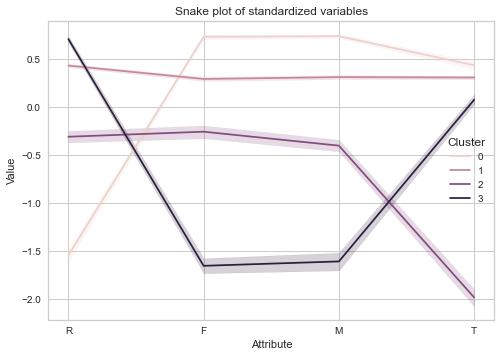

In [24]:

datamart_melt = pd.melt(datamart_normalized.reset_index(),
id_vars=['CustomerID', 'Cluster'],
value_vars=['R', 'F', 'M', 'T'],
var_name='Attribute',
value_name='Value')

plt.title('Snake plot of standardized variables')
sns.lineplot(x="Attribute", y="Value", hue='Cluster', data=datamart_melt)